[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ourownstory/neural_prophet/blob/master/tutorials/feature-use/global_modeling.ipynb)

# Global Model
When fitting a single forecasting model with shared weights using a dataset composed of many time series, we can achieve what is known as a **global model**. It is specially useful in cases in which a single time series may not reflect the entire time series dynamics. In addition, global models provide better generalization and model size saving. In this notebook, we will build a global model using data from the hourly load of the ERCOT region.

First, we load the data:

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
    #!pip install neuralprophet # much faster, but may not have the latest upgrades/bugfixes

import pandas as pd
from neuralprophet import NeuralProphet, set_log_level
from neuralprophet import set_random_seed
set_random_seed(8)
set_log_level("ERROR", "INFO")

In [2]:
data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"
df_ercot = pd.read_csv(data_location + "energy/ERCOT_load.csv")
df_ercot.head()

,ds,COAST,EAST,FAR_WEST,NORTH,NORTH_C,SOUTHERN,SOUTH_C,WEST,y
0,2004-01-01 01:00:00,7225.09,877.79,1044.89,745.79,7124.21,1660.45,3639.12,654.61,22971.94
1,2004-01-01 02:00:00,6994.25,850.75,1032.04,721.34,6854.58,1603.52,3495.16,639.88,22191.52
2,2004-01-01 03:00:00,6717.42,831.63,1021.10,699.70,6639.48,1527.99,3322.70,623.42,21383.44
3,2004-01-01 04:00:00,6554.27,823.56,1015.41,691.84,6492.39,1473.89,3201.72,613.49,20866.56
4,2004-01-01 05:00:00,6511.19,823.38,1009.74,686.76,6452.26,1462.76,3163.74,613.32,20723.15


We extract the name of the regions which will be later used in the model creation.

In [3]:
regions = list(df_ercot)[1:-1]

We select data from a three years interval in our example (from 2004 to 2007). A list of dataframes is created which will be used in case of global normalization. We also create a dict of dataframes which will be later used in case of local normalization. Each list term or dict term represents a region.

In [4]:
df_list = list()
df_dict = {}
for cols in regions:
    aux = df_ercot[['ds', cols]].copy() #select column associated with region
    aux = aux.iloc[:26301, :].copy() #selects data up to 26301 row (2004 to 2007 time stamps)
    aux = aux.rename(columns = {cols: 'y'}) #rename column of data to 'y' which is compatible with Neural Prophet
    df_list.append(aux)
    df_dict[cols] = aux

We are going to define a model which predicts the next hour based on the last 24 hours. At first, we are going to split our data into train and test (with a 33% test proportion - 2 years train and 1 year test).

In [5]:
m = NeuralProphet(n_lags = 24)
df_train_list, df_test_list = m.split_df(df_list, freq = 'H', valid_p = 0.33)

Global modeling lets us train our model based on a global or a local normalization. In the latter, each time series is normalized locally (each time series has its respective data params). In the former, we have unique data params which will be used in all the time series at hand. 

## Global modeling - Global Normalization

First, we call NeuralProphet and fit the model with the list of dataframes.

In [6]:
m = NeuralProphet(n_lags = 24)
metrics = m.fit(df_train_list, freq = 'H')

  0%|          | 0/357 [00:00<?, ?it/s]

  0%|          | 0/357 [00:00<?, ?it/s]

  0%|          | 0/357 [00:00<?, ?it/s]

We can visualize the parameters of the trained models.

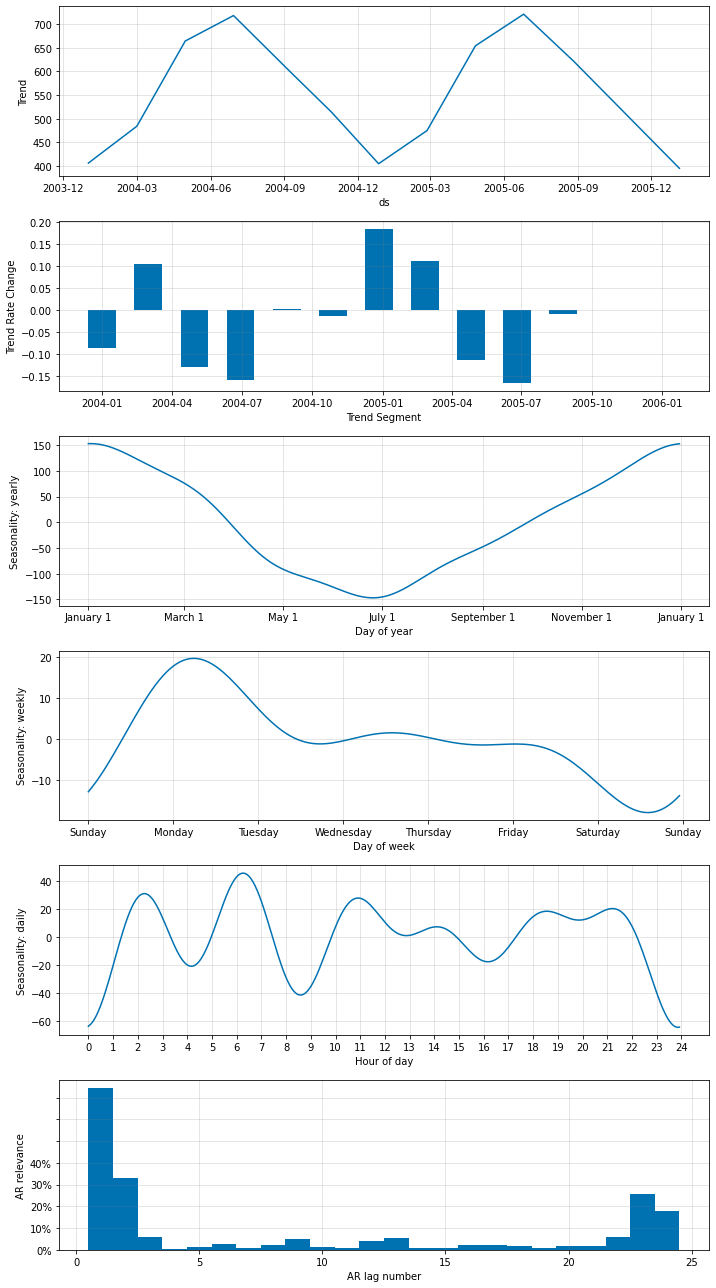

In [7]:
fig_param = m.plot_parameters()

We can evaluate the test metrics considering the list of dataframes of all regions.

In [8]:
test_metrics = m.test(df_test_list)
test_metrics

,SmoothL1Loss,MAE,RMSE
0,0.000978,487.093055,507.821381


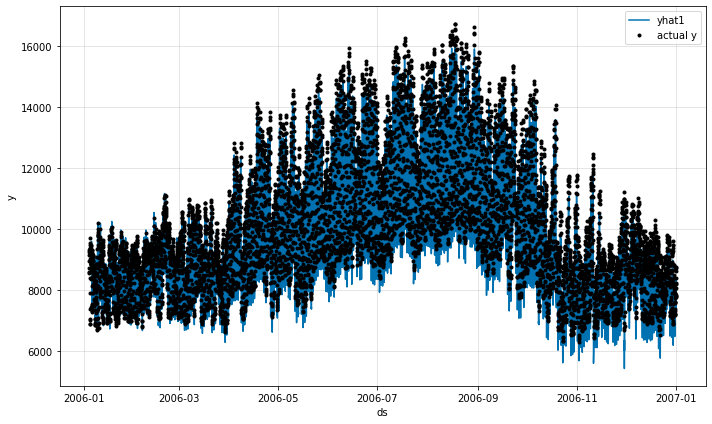

In [9]:
future = m.make_future_dataframe(df_test_list, n_historic_predictions = True)
forecast = m.predict(future)
fig = m.plot(forecast[0])

## Global Modeling - Local normalization

When using local normalization, a dict of dataframes is adopted, so each of the dict cells is associated with each respective name. Notice that we will split the data again, so the dict structure is preserved to train and test data.

In [10]:
m = NeuralProphet(n_lags = 24, local_normalization = True)
df_train_dict, df_test_dict = m.split_df(df_dict, freq = 'H', valid_p = 0.33, local_split = True)

In [11]:
metrics = m.fit(df_train_dict, freq = 'H')

  0%|          | 0/357 [00:00<?, ?it/s]

  0%|          | 0/357 [00:00<?, ?it/s]

  0%|          | 0/357 [00:00<?, ?it/s]

Please note that in the case of local normalization, the test metrics are not re-scaled but displayed on a normalized scale.

In [12]:
test_metrics = m.test(df_test_dict)
test_metrics

,SmoothL1Loss,MAE,RMSE
0,0.000515,0.026961,0.03174


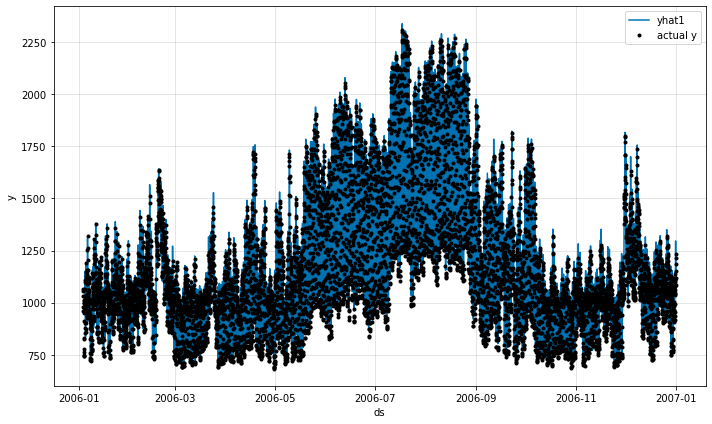

In [13]:
future = m.make_future_dataframe(df_test_dict, n_historic_predictions = True)
forecast = m.predict(future)
fig = m.plot(forecast['NORTH'])